In [1]:
%run imports.ipynb

In [2]:
import dadi
import sys
import os
import numpy
import dadi
from datetime import datetime

In [3]:
snps = "dadi/GM_GW_4out_3_dec.txt"

In [5]:
dd = dadi.Misc.make_data_dict(snps)

In [9]:
proj = [130, 182]

In [10]:
pop_ids=["GM", "GW"]

In [14]:
fs_fw = dadi.Spectrum.from_data_dict(dd, pop_ids=pop_ids, projections = proj, polarized = False)

In [15]:
print("\n\n============================================================================")
print("\nData for site frequency spectrum:\n")
print("Projection: {}".format(proj))
print("Sample sizes: {}".format(fs_fw.sample_sizes))
print("Sum of SFS: {}".format(np.around(fs_fw.S(), 2)))
print("\n============================================================================\n")




Data for site frequency spectrum:

Projection: [130, 182]
Sample sizes: [130 182]
Sum of SFS: 444394.0




In [16]:
def parse_params(param_number, in_params=None, in_upper=None, in_lower=None):
    #--------------------------------------------------------------------------------------
    # function to correctly deal with parameters and bounds, if none were provided, generate them automatically
    
    # Arguments
    # param_number: number of parameters in the model selected (can count in params line for the model)
    # in_params: a list of parameter values 
    # in_upper: a list of upper bound values
    # in_lower: a list of lower bound values
    #--------------------------------------------------------------------------------------
    param_number = int(param_number)
    
    #param set
    if in_params is None:
        params = [1] * param_number
    elif len(in_params) != param_number:
        raise ValueError("Set of input parameters does not contain the correct number of values: {}".format(param_number))
    else:
        params = in_params
        
    #upper bound    
    if in_upper is None:
        upper_bound = [30] * param_number
    elif len(in_upper) != param_number:
        raise ValueError("Upper bound set for parameters does not contain the correct number of values: {}".format(param_number))
    else:
        upper_bound = in_upper
        
    #lower bounds
    if in_lower is None:
        lower_bound = [0.01] * param_number
    elif len(in_lower) != param_number:
        raise ValueError("Lower bound set for parameters does not contain the correct number of values: {}".format(param_number))
    else:
        lower_bound = in_lower
        
    return params, upper_bound, lower_bound

def parse_opt_settings(rounds, reps=None, maxiters=None, folds=None):
    #--------------------------------------------------------------------------------------
    # function to correctly deal with replicate numbers, maxiter and fold args
    
    # Arguments
    # rounds: number of optimization rounds to perform
    # reps: a list of integers controlling the number of replicates in each of three optimization rounds
    # maxiters: a list of integers controlling the maxiter argument in each of three optimization rounds
    # folds: a list of integers controlling the fold argument when perturbing input parameter values
    #--------------------------------------------------------------------------------------
    rounds = int(rounds)
    
    #rep set
    #create scheme where final replicates will be 20, and all previous 10
    if reps is None:
        if rounds >= 2:
            reps_list = [10] * (rounds-1)
            reps_list.insert(len(reps_list),20)
        else:
            reps_list = [10] * rounds
    elif len(reps) != rounds:
        raise ValueError("List length of replicate values does match the number of rounds: {}".format(rounds))
    else:
        reps_list = reps
        
    #maxiters   
    if maxiters is None:
        maxiters_list = [5] * rounds
    elif len(maxiters) != rounds:
        raise ValueError("List length of maxiter values does match the number of rounds: {}".format(rounds))
    else:
        maxiters_list = maxiters
        
    #folds
    #create scheme so if rounds is greater than three, will always end with two fold and then one fold
    if folds is None:
        if rounds >= 3:
            folds_list = [3] * (rounds-2)
            folds_list.insert(len(folds_list),2)
            folds_list.insert(len(folds_list),1)
        elif rounds == 2:
            folds_list = [2] * (rounds-1)
            folds_list.insert(len(folds_list),1)
        else:
            folds_list = [2] * rounds
    elif len(folds) != rounds:
        raise ValueError("List length of fold values does match the number of rounds: {}".format(rounds))
    else:
        folds_list = folds
        
    return reps_list, maxiters_list, folds_list

def collect_results(fs, sim_model, params_opt, roundrep, fs_folded):
    #--------------------------------------------------------------------------------------
    # gather up a bunch of results, return a list = [roundnum_repnum, log-likelihood, AIC, chi^2 test stat, theta, parameter values] 
    
    # Arguments
    # fs: spectrum object name
    # sim_model: model fit with optimized parameters
    # params_opt: list of the optimized parameters
    # fs_folded: a Boolean (True, False) for whether empirical spectrum is folded or not
    #--------------------------------------------------------------------------------------

    #calculate likelihood
    ll = dadi.Inference.ll_multinom(sim_model, fs)
    ll = numpy.around(ll, 2)
    print("\t\t\tLikelihood = {:,}".format(ll))

    #calculate AIC 
    aic = ( -2*( float(ll))) + (2*len(params_opt))
    print("\t\t\tAIC = {:,}".format(aic))

    #calculate theta
    theta = dadi.Inference.optimal_sfs_scaling(sim_model, fs)
    theta = numpy.around(theta, 2)
    print("\t\t\tTheta = {:,}".format(theta))

    #get Chi^2
    scaled_sim_model = sim_model*theta
    if fs_folded is True:
        #calculate Chi^2 statistic for folded
        folded_sim_model = scaled_sim_model.fold()
        chi2 = numpy.sum((folded_sim_model - fs)**2/folded_sim_model)
        chi2 = numpy.around(chi2, 2)
    elif fs_folded is False:
        #calculate Chi^2 statistic for unfolded
        chi2 = numpy.sum((scaled_sim_model - fs)**2/scaled_sim_model)
        chi2 = numpy.around(chi2, 2)
    print("\t\t\tChi-Squared = {:,}".format(chi2))        

    #store key results in temporary sublist, append to larger results list
    temp_results = [roundrep, ll, aic, chi2, theta, params_opt]

    return temp_results

def write_log(outfile, model_name, rep_results, roundrep):
    #--------------------------------------------------------------------------------------
    #reproduce replicate log to bigger log file, because constantly re-written
    
    # Arguments =
    # outfile: prefix for output naming
    # model_name: a label to slap on the output files; ex. "no_mig"
    # rep_results: the list returned by collect_results function: [roundnum_repnum, log-likelihood, AIC, chi^2 test stat, theta, parameter values]
    # roundrep: name of replicate (ex, "Round_1_Replicate_10")
    #--------------------------------------------------------------------------------------
    fh_log = open("{0}.{1}.log.txt".format(outfile, model_name), 'a')
    fh_log.write("\n{}\n".format(roundrep))
    templogname = "{}.log.txt".format(model_name)
    try:
        fh_templog = open(templogname, 'r')
        for line in fh_templog:
            fh_log.write(line)
        fh_templog.close()
    except IOError:
        print("Nothing written to log file this replicate...")
    fh_log.write("likelihood = {}\n".format(rep_results[1]))
    fh_log.write("theta = {}\n".format(rep_results[4]))
    fh_log.write("Optimized parameters = {}\n".format(rep_results[5]))
    fh_log.close()

def Optimize_Routine(fs, pts, outfile, model_name, func, rounds, param_number, fs_folded=True,
                         reps=None, maxiters=None, folds=None, in_params=None,
                         in_upper=None, in_lower=None, param_labels=" "):
    #--------------------------------------------------------------------------------------
    # Mandatory Arguments =
    #(1) fs:  spectrum object name
    #(2) pts: grid size for extrapolation, list of three values
    #(3) outfile:  prefix for output naming
    #(4) model_name: a label to slap on the output files; ex. "no_mig"
    #(5) func: access the model function from within 'moments_optimize.py' or from a separate python model script, ex. Models_2D.no_mig
    #(6) rounds: number of optimization rounds to perform
    #(7) param_number: number of parameters in the model selected (can count in params line for the model)
    #(8) fs_folded: A Boolean value (True or False) indicating whether the empirical fs is folded (True) or not (False). Default is True.

    # Optional Arguments =
    #(9) reps: a list of integers controlling the number of replicates in each of three optimization rounds
    #(10) maxiters: a list of integers controlling the maxiter argument in each of three optimization rounds
    #(11) folds: a list of integers controlling the fold argument when perturbing input parameter values
    #(12) in_params: a list of parameter values 
    #(13) in_upper: a list of upper bound values
    #(14) in_lower: a list of lower bound values
    #(15) param_labels: list of labels for parameters that will be written to the output file to keep track of their order
    #--------------------------------------------------------------------------------------

    #call function that determines if our params and bounds have been set or need to be generated for us
    params, upper_bound, lower_bound = parse_params(param_number, in_params, in_upper, in_lower)

    #call function that determines if our replicates, maxiter, and fold have been set or need to be generated for us
    reps_list, maxiters_list, folds_list = parse_opt_settings(rounds, reps, maxiters, folds)
    
    print("\n\n============================================================================"
              "\nModel {}\n============================================================================\n\n".format(model_name))

    #start keeping track of time it takes to complete optimizations for this model
    tbr = datetime.now()
    
    # We need an output file that will store all summary info for each replicate, across rounds
    outname = "{0}.{1}.optimized.txt".format(outfile, model_name)
    with open(outname, 'a') as fh_out:
        fh_out.write("Model\tReplicate\tlog-likelihood\tAIC\tchi-squared\ttheta\toptimized_params({})\n".format(param_labels))
        
    #Create list to store sublists of [roundnum_repnum, log-likelihood, AIC, chi^2 test stat, theta, parameter values] for every replicate
    results_list = []
    
    #for every round, execute the assigned number of replicates with other round-defined args (maxiter, fold, best_params)
    rounds = int(rounds)
    for r in range(rounds):
        print("\tBeginning Optimizations for Round {}:".format(r+1))
       
        #make sure first round params are assigned (either user input or auto generated)
        if r == int(0):
            best_params = params
        #and that all subsequent rounds use the params from a previous best scoring replicate
        else:
            best_params = results_list[0][5]

        #perform an optimization routine for each rep number in this round number
        for rep in range(1, (reps_list[r]+1) ):
            print("\n\t\tRound {0} Replicate {1} of {2}:".format(r+1, rep, (reps_list[r])))
            
            #keep track of start time for rep
            tb_rep = datetime.now()
            
            #create an extrapolating function 
            func_exec = dadi.Numerics.make_extrap_log_func(func)
            
            #perturb starting parameters
            params_perturbed = dadi.Misc.perturb_params(best_params, fold=folds_list[r],
                                                            upper_bound=upper_bound, lower_bound=lower_bound)
            
            print("\n\t\t\tStarting parameters = [{}]".format(", ".join([str(numpy.around(x, 6)) for x in params_perturbed])))
            
            #optimize from perturbed parameters
            params_opt = dadi.Inference.optimize_log_fmin(params_perturbed, fs, func_exec, pts,
                                                              lower_bound=lower_bound, upper_bound=upper_bound,
                                                              verbose=1, maxiter=maxiters_list[r],
                                                              output_file = "{}.log.txt".format(model_name))
            
            print("\t\t\tOptimized parameters =[{}]\n".format(", ".join([str(numpy.around(x, 6)) for x in params_opt[0]])))
            
            #simulate the model with the optimized parameters
            sim_model = func_exec(params_opt[0], fs.sample_sizes, pts)

            #collect results into a list using function above - [roundnum_repnum, log-likelihood, AIC, chi^2 test stat, theta, parameter values]
            roundrep = "Round_{0}_Replicate_{1}".format(r+1, rep)
            rep_results = collect_results(fs, sim_model, params_opt[0], roundrep, fs_folded)
            
            #reproduce replicate log to bigger log file, because constantly re-written
            write_log(outfile, model_name, rep_results, roundrep)
            
            #append results from this sim to larger list
            results_list.append(rep_results)
            
            #write all this info to our main results file
            with open(outname, 'a') as fh_out:
                #join the param values together with commas
                easy_p = ",".join([str(numpy.around(x, 4)) for x in rep_results[5]])
                fh_out.write("{0}\t{1}\t{2}\t{3}\t{4}\t{5}\t{6}\n".format(model_name, rep_results[0],
                                                                              rep_results[1], rep_results[2],
                                                                              rep_results[3], rep_results[4],
                                                                              easy_p))

            #calculate elapsed time for replicate
            tf_rep = datetime.now()
            te_rep = tf_rep - tb_rep
            print("\n\t\t\tReplicate time: {0} (H:M:S)\n".format(te_rep))

        #Now that this round is over, sort results in order of likelihood score
        #we'll use the parameters from the best rep to start the next round as the loop continues
        results_list.sort(key=lambda x: float(x[1]), reverse=True)
        print("\n\t----------------------------------------------\n"
                  "\tBest replicate: {0}\n"
                  "\t\tLikelihood = {1:,}\n\t\tAIC = {2:,}\n"
                  "\t\tChi-Squared = {3:,}\n\t\tParams = [{4}]\n"
                  "\t----------------------------------------------\n\n".format(results_list[0][0],
                                                                              results_list[0][1],
                                                                              results_list[0][2],
                                                                              results_list[0][3],
                                                                              ", ".join([str(numpy.around(x, 4)) for x in rep_results[5]])))

    #Now that all rounds are over, calculate elapsed time for the whole model
    tfr = datetime.now()
    ter = tfr - tbr
    print("\nAnalysis Time for Model '{0}': {1} (H:M:S)\n\n"
              "============================================================================".format(model_name, ter))

    #cleanup file
    os.remove("{}.log.txt".format(model_name))
    



In [17]:
prefix = "_".join(pop_ids)

In [18]:
pts = [proj[0] + 10, proj[0] + 20, proj[0] + 30]
pts

[140, 150, 160]

In [19]:
rounds = 4

In [20]:
reps = [10,20,30,40]
maxiters = [3,5,10,15]
folds = [3,2,2,1]

In [21]:
fs_folded = False

In [22]:
import Models_2D

In [23]:
Optimize_Routine(fs_fw, pts, prefix, "no_mig", Models_2D.no_mig, rounds, 3, fs_folded=fs_folded,
                                        reps=reps, maxiters=maxiters, folds=folds, param_labels = "nu1, nu2, T")



Model no_mig


	Beginning Optimizations for Round 1:

		Round 1 Replicate 1 of 10:

			Starting parameters = [0.979039, 0.802168, 3.703612]
			Optimized parameters =[0.978002, 0.793375, 3.249099]

			Likelihood = -1,843,690.69
			AIC = 3,687,387.38
			Theta = 35,819.54


ValueError: Cannot operate with a folded Spectrum and an unfolded one.

--------------------------------------------
Summarize

In [47]:
os.chdir("../output_files/") 
  
print("Directory changed") 

Directory changed


In [48]:
import sys
import os

#===========================================================================
file_dir = "../output_files/"
os.chdir(file_dir)

#check if summary files already exist in output directory
results = sorted([os.path.abspath(f) for f in os.listdir(file_dir) if f.startswith("Results_Summary")])
if results:
    raise ValueError("\n\n\nWARNING: Summary files are already located in the directory specified."
                         " Please remove them before running this script.\n\n")
    

#initiate empty lists that we will fill with summary information
summary_list = []
simple_list = []

#list comprehension to find output files
flist = sorted([os.path.abspath(f) for f in os.listdir(file_dir) if f.endswith("optimized.txt")])

#do tasks depending on whether files located or not
if flist:
    print("\n\nFound {} output files to summarize:".format(len(flist)))
    for f in flist:
        print("\t{}".format(f.split('/')[-1]))
else:
    print("\n\nFound {} output files to summarize!\n\n".format(len(flist)))
    print("Please check to make sure the output files end with '.optimized.txt' and are"
              "located in the directory specified:\n\t{}".format(file_dir))

#iterate over output files
for f in flist:
    print("\nExtracting contents from: {}".format(f.split('/')[-1]))
    #content list items will have order: "Model"	"Replicate"	"log-likelihood"	"AIC"	"chi-squared"	"theta"	"optimized_params(xxx)"
    with open(f, 'r') as fh:
        lines = [line.strip().split('\t') for line in fh if not line.startswith("Model")]
    #strict filtering: sublists must have 7 elements and not contain any "nan" entries
    content = [l for l in lines if len(l) == 7 and "nan" not in l]
    if len(lines) == len(content):
        print("\tFound {} total replicates.".format(len(lines)))
    else:
        print("\tFound {} row entries.".format(len(lines)))
        print("\tRemoved {} row entries due to presence of 'nan' values or incomplete data.".format(len(lines)-len(content)))
        
    #let's sort all the rows by AIC, lowest to highest
    content.sort(key=lambda x: float(x[3]))
        
    #add top five entries to summary list
    for i in content[:5]:
        summary_list.append(i)
        
    #add top entry to easy list
    simple_list.append(content[0])
   
 #make sure results are actually in lists
if simple_list and summary_list:
    
    #sort the list containing only the top entry for each model by order of AIC
    simple_list.sort(key=lambda x: float(x[3]))

    #create output file 1
    out1 = "Results_Summary_Extended.txt"
    with open(out1, 'a') as fh:
        #write tab-delimited file with extended results
        fh.write("Model\tReplicate\tlog-likelihood\tAIC\tchi-squared\ttheta\toptimized_params\n")
        for row in summary_list:
            for val in row:
                fh.write("{}\t".format(val))
            fh.write("\n")

    #create output file 2
    out2 = "Results_Summary_Short.txt"
    with open(out2, 'a') as fh:
        #write tab-delimited file with simplified results
        fh.write("Model\tReplicate\tlog-likelihood\tAIC\tchi-squared\ttheta\toptimized_params\n")
        for row in simple_list:
            for val in row:
                fh.write("{}\t".format(val))
            fh.write("\n")

    print("\n\nSummary files '{0}' and '{1}' have been written to: \n\t{2}\n\n".format(out1, out2, file_dir))

else:
    print("\n\nNo results were written!\n\n")




Found 1 output files to summarize:
	GM_GW.no_mig.optimized.txt

Extracting contents from: GM_GW.no_mig.optimized.txt
	Found 100 total replicates.


Summary files 'Results_Summary_Extended.txt' and 'Results_Summary_Short.txt' have been written to: 
	../output_files/




In [58]:
pd.read_csv("Results_Summary_Extended.txt", sep = "\t")

,Model,Replicate,log-likelihood,AIC,chi-squared,theta,optimized_params
no_mig,Round_4_Replicate_3,-106238.21,212482.42,197498.68,41219.76,"3.2485,13.6004,0.0389",NaN
no_mig,Round_4_Replicate_24,-106268.79,212543.58,195462.74,41807.23,"3.157,12.4632,0.038",NaN
no_mig,Round_4_Replicate_1,-106270.16,212546.32,196039.11,41591.49,"3.1873,13.7313,0.038",NaN
no_mig,Round_4_Replicate_36,-106275.43,212556.86,197135.65,41420.00,"3.1997,12.9165,0.0387",NaN
no_mig,Round_4_Replicate_31,-106301.62,212609.24,193555.50,42281.26,"3.072,12.8155,0.0368",NaN


In [49]:
pd.read_csv("Results_Summary_Short.txt", sep = "\t")

,Model,Replicate,log-likelihood,AIC,chi-squared,theta,optimized_params
no_mig,Round_4_Replicate_3,-106238.21,212482.42,197498.68,41219.76,"3.2485,13.6004,0.0389",NaN


----------------------------
Plotting model

In [65]:
file_dir = "../output_files/"
os.chdir(file_dir)

In [118]:
import Plotting_Functions

In [119]:
emp_params = [3.2485,13.6004,0.0389]

In [120]:
model_fit = Plotting_Functions.Fit_Empirical(fs_fw, pts, prefix, "no_mig", no_mig, emp_params, fs_folded=False)

Fitting model 'no_mig' to empirical data...

Input parameters = [3.2485, 13.6004, 0.0389]



			Likelihood = -106,242.03
			AIC = 212,490.06
			Theta = 41,237.56
			Chi-Squared = nan

Creating plots




Plotting GM_GW_no_mig.pdf

NOTE - CLOSE PLOT TO ADVANCE.


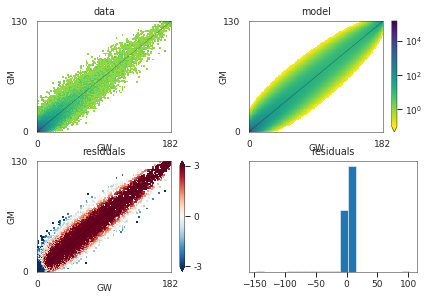

In [121]:
Plotting_Functions.Plot_2D(fs_fw, model_fit, prefix, "no_mig", vmin_val=0.1)

In [146]:
def Plot_2d(fs, model_fit, model_name, outfile, vmin_val=None):
    #Routine for plotting with 2D jsfs
    fig = pylab.figure(num = 1, figsize = (15,10))
    fig.clear()
    if vmin_val is None:
        dadi.Plotting.plot_2d_comp_multinom(model_fit, fs, resid_range = 3)
    else:
        dadi.Plotting.plot_2d_comp_multinom(model_fit, fs, resid_range = 3, vmin = vmin_val)
    print('\nPlotting {0}_{1}.pdf'.format(outfile, model_name))
    print("\nNOTE - CLOSE PLOT TO ADVANCE.")
    outname = '{0}_{1}.pdf'.format(outfile, model_name)
    fig.savefig(outname)

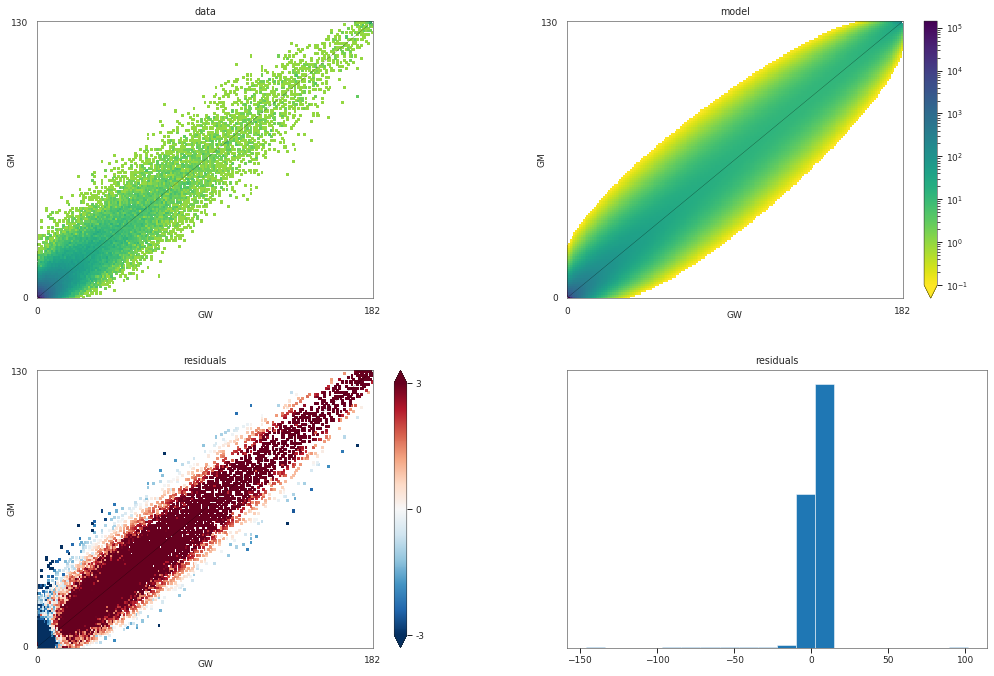


Plotting no_mig_GM_GW.png

NOTE - CLOSE PLOT TO ADVANCE.


In [147]:
Plot_2d(fs_fw, model_fit, prefix, "no_mig", vmin_val=0.1)